In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib qt
from tqdm import tqdm
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import detrend
from matplotlib import pyplot as plt
import matplotlib as mpl

from vrAnalysis.helpers import errorPlot
from photometry.loaders import get_doric_files, process_data_parallel, process_single_file
from photometry.process import analyze_data, resample_with_antialiasing

from syd import make_viewer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
mouse_name = "ATL065"
dirs, findex, data = get_doric_files(mouse_name)
print(f"Found {len(data)} files")

Found 20 files


In [3]:
# Get the results from all sessions of this mouse
preperiod = 0.2
postperiod = 1.0
results, average = process_data_parallel(data, preperiod=preperiod, postperiod=postperiod)

Processing files: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


In [5]:
import numpy as np
from scipy import signal
from scipy.signal import detrend

def detrend_methods(time_series, sampling_rate):
    """
    Apply multiple detrending methods to a photometry time series.
    
    Parameters:
    -----------
    time_series : array-like
        Raw photometry signal
    sampling_rate : float
        Sampling rate in Hz
    
    Returns:
    --------
    dict : Dictionary containing detrended signals using different methods
    """
    results = {}
    
    # 1. Linear detrending (scipy)
    results['linear'] = detrend(time_series)
    
    # 2. Rolling percentile subtraction
    def rolling_percentile_detrend(data, window_size=60, percentile=10):
        # Convert window size from seconds to samples
        window_samples = int(window_size * sampling_rate)
        # Ensure window size is odd
        if window_samples % 2 == 0:
            window_samples += 1
        
        baseline = np.array([np.percentile(data[max(0, i-window_samples//2):min(len(data), i+window_samples//2)], 
                                         percentile) 
                           for i in range(len(data))])
        return data - baseline
    
    results['rolling_percentile'] = rolling_percentile_detrend(time_series)
    
    # 3. Polynomial detrending
    def polynomial_detrend(data, order=3):
        x = np.arange(len(data))
        coeffs = np.polyfit(x, data, order)
        trend = np.polyval(coeffs, x)
        return data - trend
    
    results['polynomial'] = polynomial_detrend(time_series)
    
    # 5. Savitzky-Golay filter
    def savgol_detrend(data, window_length=301, poly_order=3):
        if window_length % 2 == 0:
            window_length += 1
        trend = signal.savgol_filter(data, window_length, poly_order)
        return data - trend
    
    results['savgol'] = savgol_detrend(time_series)
    
    # 6. High-pass filtering
    def highpass_detrend(data, cutoff_freq=0.01):
        nyquist = sampling_rate / 2
        b, a = signal.butter(3, cutoff_freq/nyquist, btype='high')
        return signal.filtfilt(b, a, data)
    
    results['highpass'] = highpass_detrend(time_series)
    
    return results

# Example usage and visualization
def plot_detrending_comparison(time_series, sampling_rate, time=None):
    """
    Plot comparison of different detrending methods
    """
    import matplotlib.pyplot as plt
    
    results = detrend_methods(time_series, sampling_rate)
    
    if time is None:
        time = np.arange(len(time_series)) / sampling_rate
    
    fig, axes = plt.subplots(len(results), 1, figsize=(12, 3*len(results)))
    fig.suptitle('Comparison of Detrending Methods')
    
    for ax, (method, detrended) in zip(axes, results.items()):
        ax.plot(time, time_series, 'gray', alpha=0.5, label='Original')
        ax.plot(time, detrended, 'b', label='Detrended')
        ax.set_title(f'{method.replace("_", " ").title()} Detrending')
        ax.legend()
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Signal')
    
    plt.tight_layout()
    return fig, results


sampling_rate = 1 / np.mean(np.diff(results[0]["time_data"]))
# plot_detrending_comparison(results[0]["data_in2"], sampling_rate, time=results[0]["time_opto"])

In [ ]:
# Let's think about how to do a better job than detrending with a linear fit...
num_sessions = len(results)

options = ["detrend", ]
viewer = make_viewer()
viewer.add_multiple_selection("filter_methods", value=["detrend"])

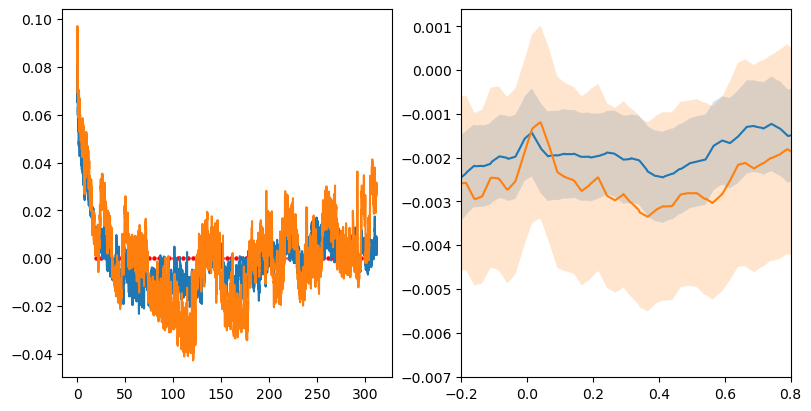

In [12]:
# For looking at a single session
ises = 9
session_results = results[ises]

fig, ax = plt.subplots(1, 2, figsize=(8, 4), layout="constrained", sharey=False)
ax[0].plot(session_results["time_data"], session_results["data_in1"], label="in1")
ax[0].plot(session_results["time_data"], session_results["data_in2"], label="in2")
ax[0].scatter(session_results["opto_start_time"], np.zeros_like(session_results["opto_start_time"]), color="red", label="opto start", s=5)

errorPlot(session_results["time_opto"], session_results["in1_opto"], se=True, axis=0, label="in1", ax=ax[1], alpha=0.2)
errorPlot(session_results["time_opto"], session_results["in2_opto"], se=True, axis=0, label="in2", ax=ax[1], alpha=0.2)
ax[1].set_xlim(-preperiod, 0.8)
plt.show()

In [10]:
# For showing a single mouse across sessions
preperiod = 0.2
postperiod = 1.0
samples = np.linspace(-preperiod, postperiod, int((postperiod - preperiod) * 1000))
session_results = []

average = []
for ifile, file in enumerate(data):
    print(f"Processing file {ifile+1}/{len(data)}")
    results = analyze_data(file, preperiod=preperiod+0.01)
    c_idx = results["time_opto"] < postperiod + preperiod
    c_time = results["time_opto"][c_idx]
    c_data = np.mean(results["in2_opto"][:, c_idx] - results["in1_opto"][:, c_idx], axis=0)
    c_interp = interp1d(c_time, c_data, kind="cubic")(samples)
    c_interp = detrend(c_interp)
    session_results.append(results)
    average.append(c_interp)
average = np.stack(average)

Processing file 1/20
Processing file 2/20
Processing file 3/20
Processing file 4/20
Processing file 5/20
Processing file 6/20
Processing file 7/20
Processing file 8/20
Processing file 9/20
Processing file 10/20
Processing file 11/20
Processing file 12/20
Processing file 13/20
Processing file 14/20
Processing file 15/20
Processing file 16/20
Processing file 17/20
Processing file 18/20
Processing file 19/20
Processing file 20/20


In [17]:
def plot(viewer, state):
    idx_session = state["idx_session"]
    colormap = state["colormap"]
    
    results = session_results[idx_session]

    cmap = plt.get_cmap(colormap)
    colors = np.array([cmap(i/len(average)) for i in range(len(average))])

    fig = plt.figure(figsize=(8, 4), layout="constrained")
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.2], wspace=0.1)

    # Plot all sessions
    ax = fig.add_subplot(gs[0])
    for iavg, avg in enumerate(average):
        ax.plot(samples, avg, color=colors[iavg] if iavg != idx_session else "k", zorder=1 if iavg != idx_session else 1000)
    ax.set_xlim(-preperiod, postperiod/2)
    ax.axhline(0, color="black", linewidth=0.5, linestyle="--", zorder=-100)

    # Plot the current session's data in particular
    ax = fig.add_subplot(gs[1])
    errorPlot(results["time_opto"], results["in1_opto"], se=True, axis=0, ax=ax, alpha=0.2, color="black", label="iso")
    errorPlot(results["time_opto"], results["in2_opto"], se=True, axis=0, ax=ax, alpha=0.2, color="green", label="fluor")
    ax.set_xlim(-preperiod, 0.8)

    ax_cbar = fig.add_subplot(gs[2])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(average)-1))
    cbar = plt.colorbar(sm, cax=ax_cbar, label='Session #')
    cbar.set_ticks([0, len(average)-1])  # Only show first and last session numbers
    cbar.set_ticklabels(['1', str(len(average))])  # Label them as 1 and max

    return fig


viewer = make_viewer(plot)
viewer.add_integer("idx_session", value=0, min_value=0, max_value=len(average)-1)
viewer.add_selection("colormap", value="rainbow", options=["rainbow", "viridis", "plasma", "magma", "cividis"])
viewer.deploy()


In [13]:
cmap = plt.get_cmap("rainbow")
colors = np.array([cmap(i/len(average)) for i in range(len(average))])

fig = plt.figure(figsize=(4, 4), layout="constrained")
gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.2], wspace=0.05)

# fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")

ax = fig.add_subplot(gs[0, 0])
for iavg, avg in enumerate(average):
    ax.plot(samples, avg, color=colors[iavg])
ax.set_xlim(-preperiod, postperiod/2)
ax.plot([0, 0.03], [-0.001, -0.001], color="black", linewidth=3)

ax_cbar = fig.add_subplot(gs[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(average)-1))
cbar = plt.colorbar(sm, cax=ax_cbar, label='Session #')
cbar.set_ticks([0, len(average)-1])  # Only show first and last session numbers
cbar.set_ticklabels(['1', str(len(average))])  # Label them as 1 and max

plt.show()

In [ ]:
# For making an average across all mice
preperiod = 0.2
postperiod = 1.0
samples = np.linspace(-preperiod, postperiod, int((postperiod - preperiod) * 1000))

mouse_list = ["ATL061", "ATL062", "ATL063", "ATL064", "ATL065"]
colors = ["red", "blue", "green", "purple", "brown"]
average = []
for mouse in tqdm(mouse_list):
    c_mouse_average = []    
    dirs, findex, data = get_doric_files(mouse)
    for file in data:
        results = analyze_data(file, preperiod=preperiod+0.01)
        c_idx = results["time_opto"] < postperiod + preperiod
        c_time = results["time_opto"][c_idx]
        c_data = np.mean(results["in2_opto"][:, c_idx] - results["in1_opto"][:, c_idx], axis=0)
        c_interp = interp1d(c_time, c_data, kind="cubic")(samples)
        c_mouse_average.append(c_interp)
    average.append(np.stack(c_mouse_average))
    if mouse == "ATL061":
        average[-1] = average[-1][:3]

In [200]:
preperiod = 0.2
postperiod = 1.0
samples = np.linspace(-preperiod, postperiod, int((postperiod - preperiod) * 1000))

mouse_list = ["ATL061", "ATL062", "ATL063", "ATL064", "ATL065"]
colors = ["red", "blue", "green", "purple", "brown"]
average = []
for mouse in tqdm(mouse_list):
    c_mouse_average = []    
    dirs, findex, data = get_doric_files(mouse)
    for file in data:
        results = analyze_data(file, preperiod=preperiod+0.01)
        c_idx = results["time_opto"] < postperiod + preperiod
        c_time = results["time_opto"][c_idx]
        c_data = np.mean(results["in2_opto"][:, c_idx] - results["in1_opto"][:, c_idx], axis=0)
        c_interp = interp1d(c_time, c_data, kind="cubic")(samples)
        c_mouse_average.append(c_interp)
    average.append(np.stack(c_mouse_average))
    if mouse == "ATL061":
        average[-1] = average[-1][:3]

100%|██████████| 5/5 [00:19<00:00,  3.80s/it]


In [207]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
for imouse, (mouse, color, avg) in enumerate(zip(mouse_list, colors, average)):
    errorPlot(samples, avg - np.mean(avg[:, 0]), se=True, axis=0, label=mouse, ax=ax, color=color, alpha=0.2)
    # ax.plot(samples, avg.T, label=mouse, color=color)
ax.set_xlim(-preperiod, postperiod/2)
ax.legend(loc="upper right")
ax.plot([0, 0.03], [-0.001, -0.001], color="black", linewidth=3)

In [212]:
plt.plot(samples, average[0].T)

: 

In [194]:
average[0][:, 0]

array([-0.03055913, -0.03442416, -0.00556974,  1.33912469])

In [160]:
[t.shape for t in times[0]]

[(62452,), (62361,), (62452,), (62452,)]